# Librerias y Preparacion

In [ ]:
import os
import time
import shutil
import pandas as pd
from tqdm import tqdm
import tarfile
import random
import os
import pandas as pd
import numpy as np
from PIL import Image
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from google.colab import files


Para descargar el dataset de PlantVillage, necesitamos un token de la API de Kaggle
Para ejecutarlo localmente:

    pip install kaggle

    Ve a: https://www.kaggle.com/settings

    Haz clic en “Create New API Token”. Esto descargará un archivo llamado kaggle.json.

Para agregar la API en un lugar seguro en sistemas MAC o Linux:

mkdir -p ~/.kaggle
mv /ruta/del/archivo/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

Para Windows:

mkdir %USERPROFILE%\.kaggle
move "C:\ruta\a\kaggle.json" "%USERPROFILE%\.kaggle\"




This is done in colab so if you are running it locally, ignore the #from google colab import files code line

## Cargar token de kaggle descargado

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"axlsaalss","key":"302aa7324809b53d3a3687a5b15b28bd"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

This code line will download de .zip file and unzip it.

In [4]:
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d plantvillage

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 81% 533M/658M [00:00<00:00, 1.40GB/s]
100% 658M/658M [00:00<00:00, 1.38GB/s]


In [26]:
source_dir = "plantvillage/PlantVillage"
classes = os.listdir(source_dir)
print(f"{len(classes)} clases encontradas.")
print("Ejemplos:", classes[:5])

15 clases encontradas.
Ejemplos: ['Pepper__bell___healthy', 'Tomato_Septoria_leaf_spot', 'Pepper__bell___Bacterial_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_Bacterial_spot']


The Dataset will download in different files depending on the plant/vegetable, this DF can be use to train, but for testing purposes, the next code will create a flat dataset that contains all the images.

## Ruta del dataset plano (ya aplanado con las imágenes en una carpeta y su labels.csv)

In [27]:
dest_dir = "flat_dataset_PlantVillage"
os.makedirs(dest_dir, exist_ok=True)

records = []
counter = 0

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        src = os.path.join(class_path, img_file)

        if os.path.isdir(src):
            continue

        new_filename = f"image_{counter:05d}.jpg"
        dst = os.path.join(dest_dir, new_filename)

        shutil.copy2(src, dst)
        records.append([new_filename, class_name])
        counter += 1

df = pd.DataFrame(records, columns=["filename", "label"])
df.to_csv(os.path.join(dest_dir, "labels.csv"), index=False)

print(f"Copied {counter} images to '{dest_dir}' and saved labels to 'labels.csv'")



Copied 20639 images to 'flat_dataset_PlantVillage' and saved labels to 'labels.csv'


In [28]:
# Rutas completas
folder1 = "plantvillage/PlantVillage"
#folder2 = "plantvillage/plantvillage/PlantVillage"

print("Clases en PlantVillage:", len(os.listdir(folder1)))
#print("Clases en plantvillage:", len(os.listdir(folder2)))

def contar_imagenes(folder):
    total = 0
    for clase in os.listdir(folder):
        clase_path = os.path.join(folder, clase)
        if os.path.isdir(clase_path):
            total += len(os.listdir(clase_path))
    return total

print("Imágenes en PlantVillage:", contar_imagenes(folder1))
#print("Imágenes en plantvillage:", contar_imagenes(folder2))
print("Clases en PlantVillage:", sorted(os.listdir(folder1))[:5])
#print("Clases en plantvillage:", sorted(os.listdir(folder2))[:5])


Clases en PlantVillage: 15
Imágenes en PlantVillage: 20639
Clases en PlantVillage: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [29]:
!rm -rf plantvillage/plantvillage



## Config y Normalizacion

1. Carga la imagen desde disco

    Lee la imagen utilizando PIL.Image.open()

2. Convierte la imagen a formato RGB

    Asegura que todas las imágenes tengan 3 canales (Rojo, Verde, Azul).

    Esto es esencial ya que algunas imágenes pueden estar en escala de grises o tener 4 canales (RGBA).

3. Redimensiona la imagen a 128x128 píxeles

    Las redes neuronales requieren que todas las entradas tengan el mismo tamaño.

    Redimensionar estandariza el tamaño y reduce la carga computacional.

4. Normaliza los valores de los píxeles

    Divide todos los valores de píxel por 255.0 para que estén en el rango [0.0, 1.0].

    Esto mejora la estabilidad numérica durante el entrenamiento (los modelos entrenan mejor con datos normalizados).

In [ ]:
# === CONFIGURACIÓN ===
dataset_dir = "flat_dataset_PlantVillage"
labels_path = os.path.join(dataset_dir, "labels.csv")
image_size = (128, 128)  # Tamaño al que redimensionaremos todas las imágenes


# Cargamos el archivo labels.csv, que contiene la columna 'filename' y 'label'
df = pd.read_csv(labels_path)
print("Total imágenes:", len(df))
print(df.head())

# Esta función abre una imagen individual, la convierte a RGB, la redimensiona al tamaño estándar
# y la normaliza dividiendo por 255.0 para que los valores estén entre 0 y 1.
def load_and_preprocess_image(filename):
    try:
        path = os.path.join(dataset_dir, filename)
        img = Image.open(path).convert("RGB")
        img = img.resize(image_size)
        arr = np.array(img) / 255.0  # Normalizamos los valores de píxel
        return arr
    except Exception as e:
        print(f"Error con {filename}: {e}")
        return None




Total imágenes: 20639
          filename                   label
0  image_00000.jpg  Pepper__bell___healthy
1  image_00001.jpg  Pepper__bell___healthy
2  image_00002.jpg  Pepper__bell___healthy
3  image_00003.jpg  Pepper__bell___healthy
4  image_00004.jpg  Pepper__bell___healthy


# Comparacion Paralelismo/Secuencial

## Paralela

### Cargar todas las imagenes con Joblib

In [31]:
start_parallel = time.time()

images_parallel = Parallel(n_jobs=-1)(
    delayed(load_and_preprocess_image)(fname) for fname in df["filename"]
)

elapsed_parallel = time.time() - start_parallel
print(f" Tiempo paralelo (Joblib): {elapsed_parallel:.2f} segundos")

 Tiempo paralelo (Joblib): 22.04 segundos


Aquí usamos Joblib para cargar las imágenes en paralelo, utilizando múltiples núcleos del CPU.
'Parallel(n_jobs=-1)' le dice a Joblib que use todos los núcleos disponibles.
'delayed(...)' permite que la función se ejecute de forma diferida y distribuida.

¿Qué hace Joblib aquí?

    Acelera el proceso de carga y preprocesamiento de imágenes.

    En lugar de cargar las 20,000 imágenes secuencialmente (una por una), las distribuye entre varios núcleos.

    Esto reduce drásticamente el tiempo de espera cuando trabajas con datasets grandes.

### Eliminar Errores

Eliminamos imágenes que no pudieron ser cargadas (por errores o archivos dañados).
Asociamos correctamente cada imagen con su etiqueta correspondiente.

In [32]:
valid_data = [(img, label) for img, label in zip(images_parallel, df["label"]) if img is not None]
X, y = zip(*valid_data) # Separamos los datos en X (imágenes) e y (etiquetas)
X = np.stack(X)
print("Shape de X:", X.shape)  # Convertimos la lista de arrays en un solo array multidimensional

# === 5. CONVERTIR ETIQUETAS A NÚMEROS Y CATEGORÍAS ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
print("Shape de y:", y_categorical.shape)
print("Clases:", label_encoder.classes_)

Shape de X: (20638, 128, 128, 3)
Shape de y: (20638, 15)
Clases: ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


## Secuencial

In [33]:
# Cargar las imágenes de manera secuencial
start_sequential = time.time()

images_sequential = []
for fname in df["filename"]:
    img = load_and_preprocess_image(fname)
    images_sequential.append(img)

elapsed_sequential = time.time() - start_sequential
print(f" Tiempo secuencial: {elapsed_sequential:.2f} segundos")

Error con image_09258.jpg: cannot identify image file 'flat_dataset_PlantVillage/image_09258.jpg'
 Tiempo secuencial: 34.64 segundos


### Eliminar Errores

In [35]:
# Limpieza de datos no válidos

label_encoder = LabelEncoder()
label_encoder.fit(df["label"])

valid_data_seq = [(img, label) for img, label in zip(images_sequential, df["label"]) if img is not None]

# Separar en X e y
X_seq, y_seq = zip(*valid_data_seq)
X_seq = np.stack(X_seq)

print("Shape secuencial de X:", X_seq.shape)

# Convertir etiquetas
y_seq_encoded = label_encoder.transform(y_seq)
y_seq_categorical = to_categorical(y_seq_encoded)

# Verificación
print("Shape secuencial de y:", y_seq_categorical.shape)

print("Clases:", label_encoder.classes_)

Shape secuencial de X: (20638, 128, 128, 3)
Shape secuencial de y: (20638, 15)
Clases: ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


## Comparativa

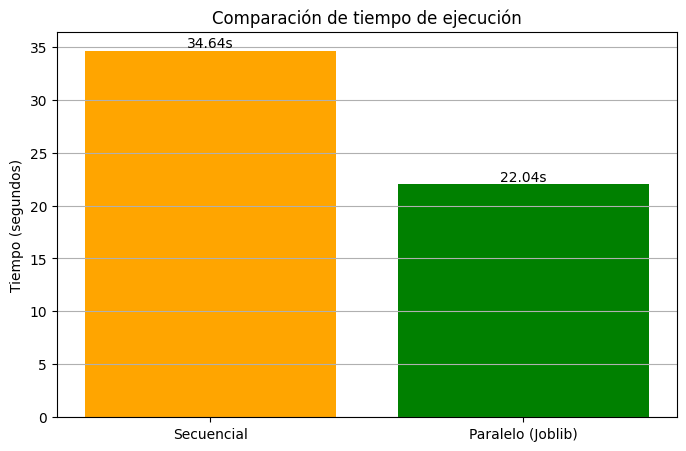

In [ ]:
# Datos de ejemplo (puedes reemplazarlos con los valores reales)
labels = ['Secuencial', 'Paralelo (Joblib)']
tiempos = [elapsed_sequential, elapsed_parallel]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, tiempos, color=['orange', 'green'])

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s', ha='center', va='bottom')

plt.title("Comparación de tiempo de ejecución")
plt.ylabel("Tiempo (segundos)")
plt.grid(axis='y')
plt.show()


In [36]:
speedup = elapsed_sequential / elapsed_parallel
print(f" Speedup con Joblib: {speedup:.2f}x más rápido")

 Speedup con Joblib: 1.57x más rápido


# Visualizacion del dataset

## Distribucion de Clases

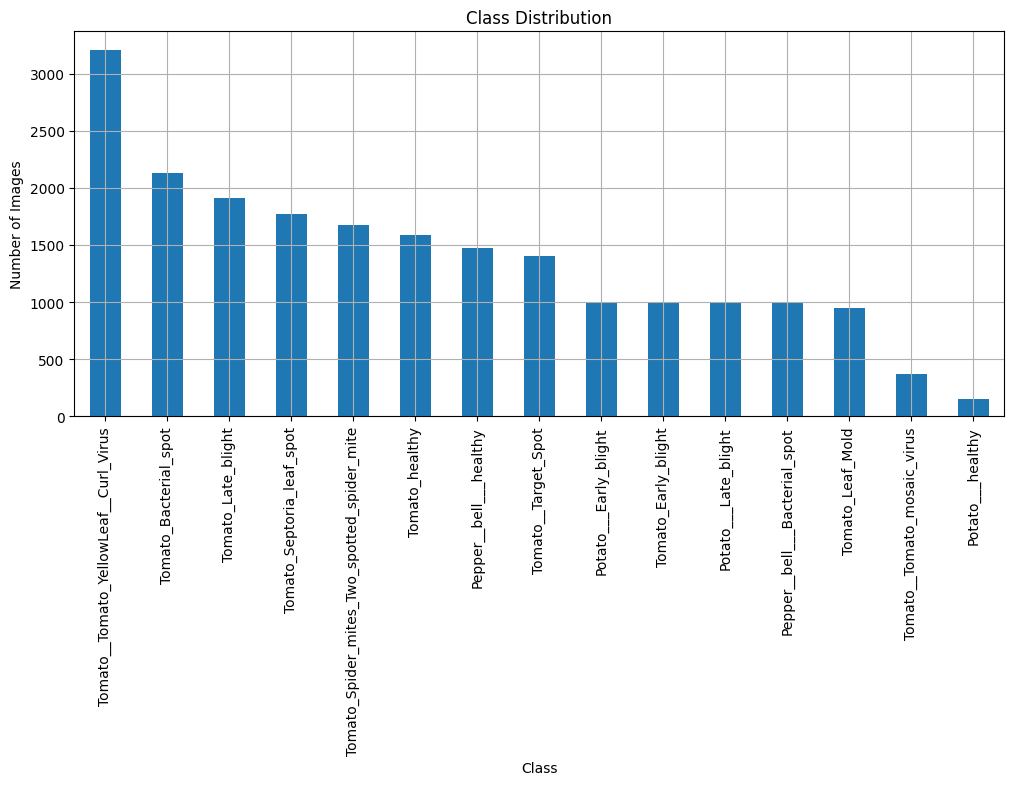

In [22]:
df['label'].value_counts().plot(kind='bar', figsize=(12, 5), title='Class Distribution')
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()


## Proporcion de Clases

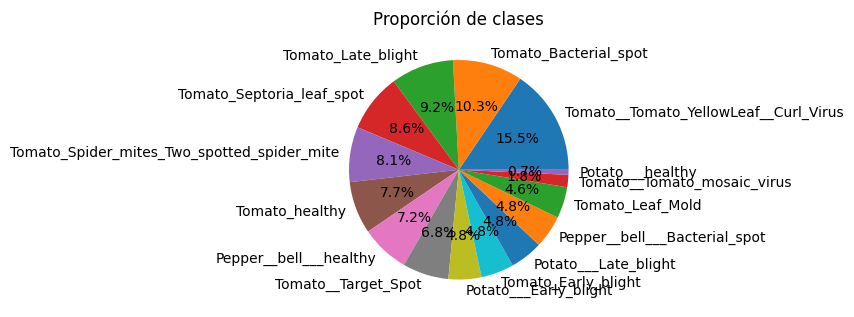

In [40]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), title='Proporción de clases')
plt.ylabel('')
plt.tight_layout()
plt.show()


## Samples de imagenes

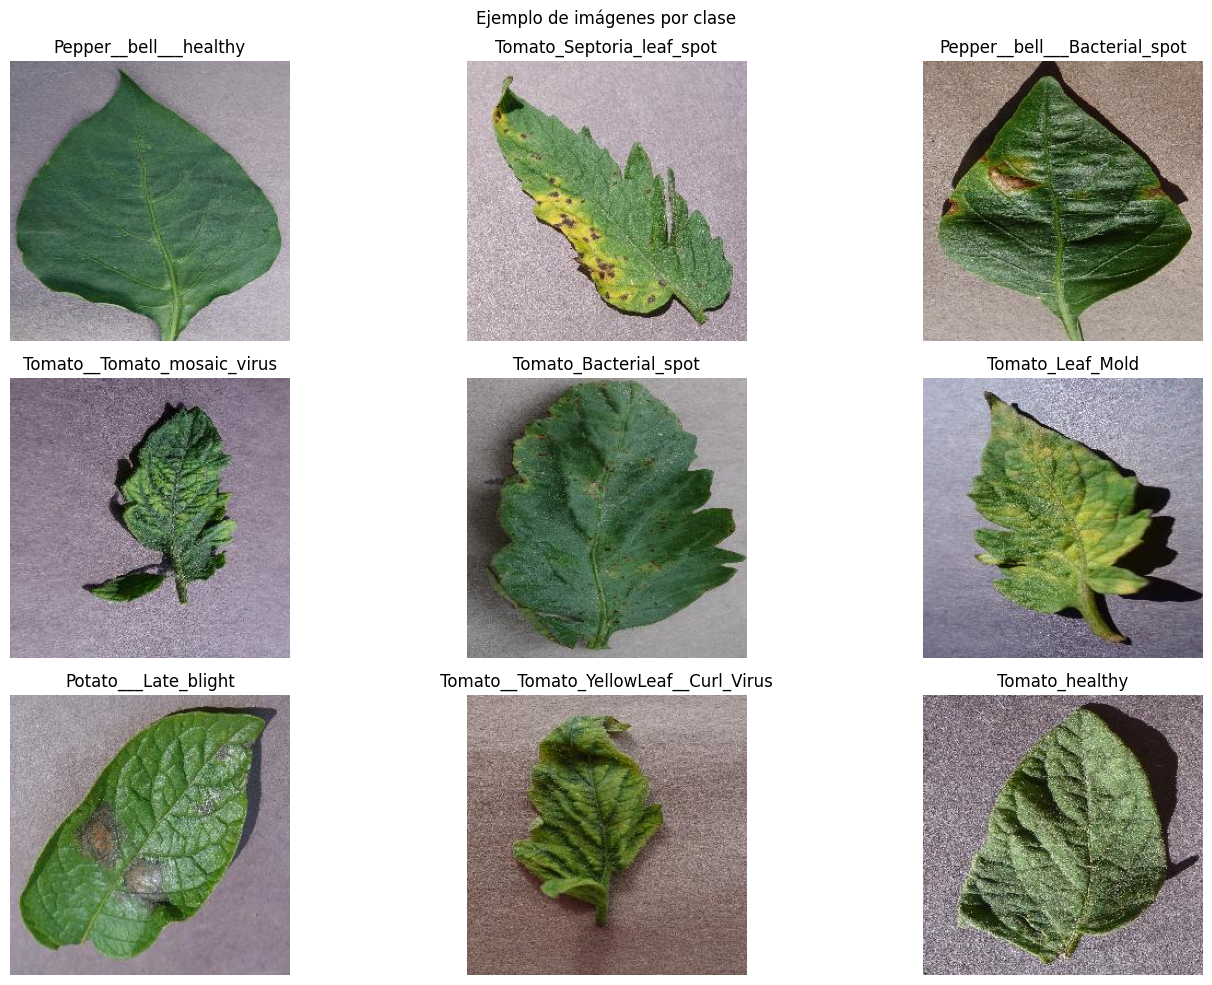

In [ ]:
# Mostrar una imagen aleatoria por clase
clases = df['label'].unique()
plt.figure(figsize=(15, 10))

for i, clase in enumerate(clases[:9]):  # ajusta el 9 si quieres ver más clases
    fila = df[df['label'] == clase]
    muestra = fila.sample(1).iloc[0]
    img_path = os.path.join(dataset_dir, muestra['filename'])
    img = Image.open(img_path)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(clase)
    plt.axis('off')

plt.suptitle("Ejemplo de imágenes por clase")
plt.tight_layout()
plt.show()


# CCN MODEL


Dividimos los datos en 80% entrenamiento y 20% prueba.
'stratify=y_categorical' asegura que las clases estén balanceadas en ambos grupos.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (16510, 128, 128, 3) Test: (4128, 128, 128, 3)


Creamos un modelo secuencial de Keras (estructura básica de una CNN)

In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')  # salida según número de clases
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Compilamos el modelo con:
 - optimizador Adam
 - función de pérdida para clasificación multiclase: categorical_crossentropy
 - métrica de evaluación: precisión (accuracy)

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Entrenamos el modelo usando los datos de entrenamiento.
'validation_split=0.1' toma el 10% de los datos de entrenamiento para validación interna.

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.4349 - loss: 1.8229 - val_accuracy: 0.8007 - val_loss: 0.6066
Epoch 2/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8365 - loss: 0.5168 - val_accuracy: 0.8474 - val_loss: 0.4546
Epoch 3/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9007 - loss: 0.2996 - val_accuracy: 0.8558 - val_loss: 0.4060
Epoch 4/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9356 - loss: 0.1946 - val_accuracy: 0.8886 - val_loss: 0.3605
Epoch 5/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9596 - loss: 0.1303 - val_accuracy: 0.8976 - val_loss: 0.3202
Epoch 6/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9659 - loss: 0.1055 - val_accuracy: 0.8661 - val_loss: 0.4754
Epoch 7/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9684 - loss: 0.0892 - val_accuracy: 0.8770 - val_loss: 0.4805
Epoch 8/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9760 - loss: 0.0760 - val_accuracy: 

Evaluamos la precisión final del modelo usando el 20% de datos reservados para prueba.

In [18]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")




129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8900 - loss: 0.4246
Test Accuracy: 0.8857


## Visualizar del entrenamiento y prediccion

### Entrenamiento y presicion de validacion por epocas

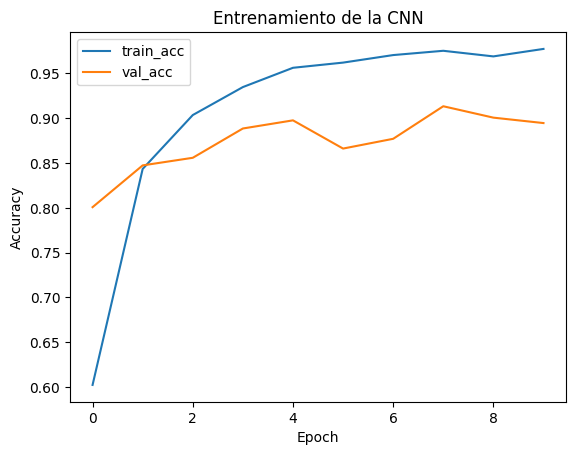

In [19]:

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Entrenamiento de la CNN")
plt.show()


### Entrenamiento y Validation loss por epocas

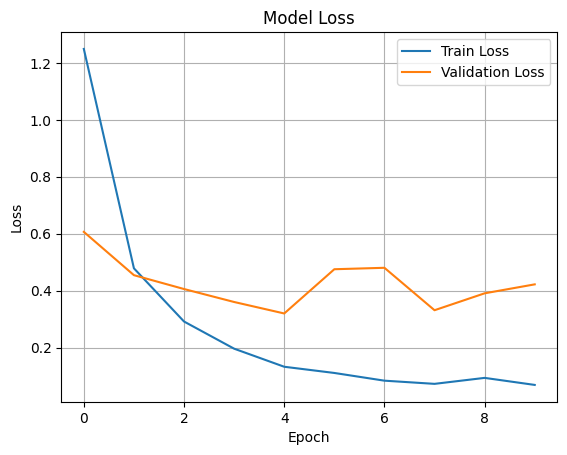

In [20]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Matriz de Confusion

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


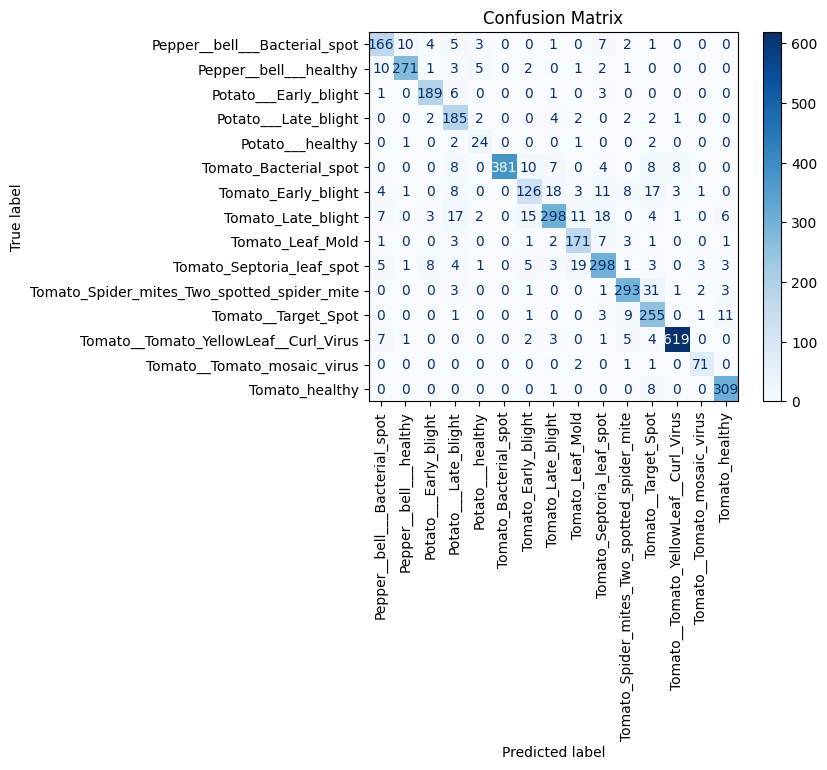

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### Samples de prediccion

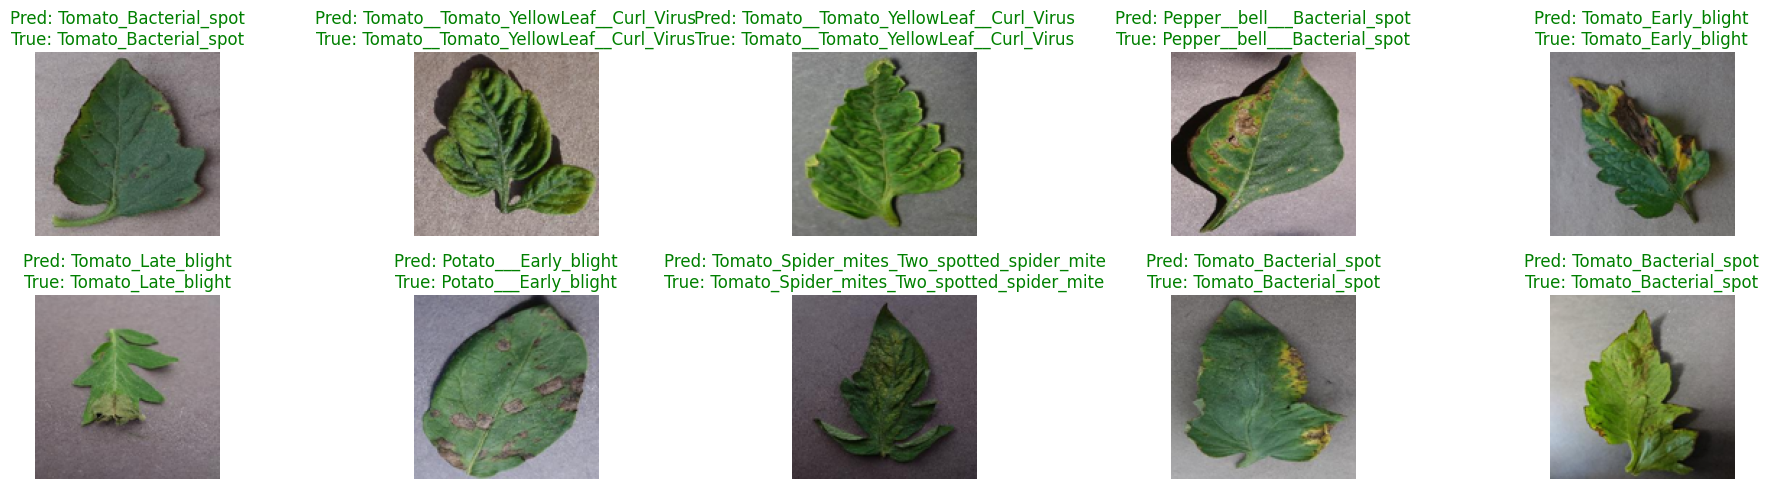

In [ ]:
n = 10
plt.figure(figsize=(20, 5))

for i in range(n):
    ax = plt.subplot(2, n//2, i+1)
    plt.imshow(X_test[i])
    pred_class = label_encoder.inverse_transform([y_pred_classes[i]])[0]
    true_class = label_encoder.inverse_transform([y_true[i]])[0]
    color = "green" if pred_class == true_class else "red"
    plt.title(f"Pred: {pred_class}\nTrue: {true_class}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()


***Los gráfico muestra que la precisión del modelo en el conjunto de entrenamiento aumenta rápidamente desde aproximadamente 58% hasta casi 99% en solo 10 épocas, lo que indica que la CNN aprende muy bien los datos que ha visto. Sin embargo, la precisión en el conjunto de validación se estabiliza entre 86% y 88% a partir de la tercera época, sin mejorar significativamente. Esta diferencia sugiere que el modelo está sobreajustando ligeramente: memoriza los datos de entrenamiento pero no generaliza con la misma efectividad a datos nuevos. A pesar de ello, alcanzar cerca del 87% de precisión en validación es un muy buen resultado inicial para este tipo de modelo.***

## Guardar modelo

In [ ]:

model.save("plantvillage_cnn_parl.h5")

# Conclusiones

## Uso de Joblib en este Dataset y model:

**Tiempo con Joblib y Paralelismo: 22 segundos**

**Tiempo sin Joblib y Secuencial: 34 segundos**

## ¿Qué hizo Joblib?

    Distribuyó la función load_and_preprocess_image() (abrir, redimensionar y normalizar cada imagen) en varios núcleos al mismo tiempo.

    Gracias a n_jobs=-1, usó todos los núcleos disponibles, logrando una ejecución mucho más rápida comparada con un bucle for tradicional.


## ¿Para qué Paralelismo?

    Para cargar más de 20,000 imágenes de forma eficiente.

    Evitar cuellos de botella por lectura secuencial.

    Mejorar el rendimiento del preprocesamiento, que es una etapa costosa en visión por computadora.